# **Introdução**

No contexto atual, onde a gestão de custos na saúde é essencial, o desenvolvimento de modelos preditivos para precificação de seguros saúde se torna vital. Como profissionais encarregados deste desafio, o objetivo é criar um modelo de regressão capaz de prever os custos médicos individuais com base em variáveis como idade, gênero, IMC, número de filhos, hábito de fumar, região de residência e encargos já cobrados.

Utilizando essa base de dados, o modelo buscará fornecer previsões precisas e identificar padrões que auxiliem na otimização da precificação.

# **Importando Bibliotecas Necessárias**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interpn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# **Importando os Dados**

In [ ]:
dataset = pd.read_csv("seguro_saude.csv")
dataset.head(10)

,idade,gênero,imc,filhos,fumante,região,encargos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,não,sudeste,1725.55230
2,28,masculino,33.000,3,não,sudeste,4449.46200
3,33,masculino,22.705,0,não,noroeste,21984.47061
4,32,masculino,28.880,0,não,noroeste,3866.85520
5,31,feminino,25.740,0,não,sudeste,3756.62160
6,46,feminino,33.440,1,não,sudeste,8240.58960
7,37,feminino,27.740,3,não,noroeste,7281.50560
8,37,masculino,29.830,2,não,nordeste,6406.41070
9,60,feminino,25.840,0,não,noroeste,28923.13692


Aqui utlizamos a biblioteca pandas para importar os dados que estão no formato texto/csv e exibimos as linhas iniciais para visualizar uma amostra dos dados e confirmar a criação de um conjunto de dados para ser trabalhado no decorrer da solução.

# **Explorando os Dados**

In [ ]:
dataset.shape

(1338, 7)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   gênero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   região    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Neste início de exploração podemos verificar que nossa base possui 1338 linhas e 7 colunas, temos 3 colunas no formato texto e as demais são núméricas. Podemos identificar também que a base não possui ausência de valores ou valores nulos em nenhuma coluna.

**Analisando as variáveis do tipo numérico**

In [ ]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


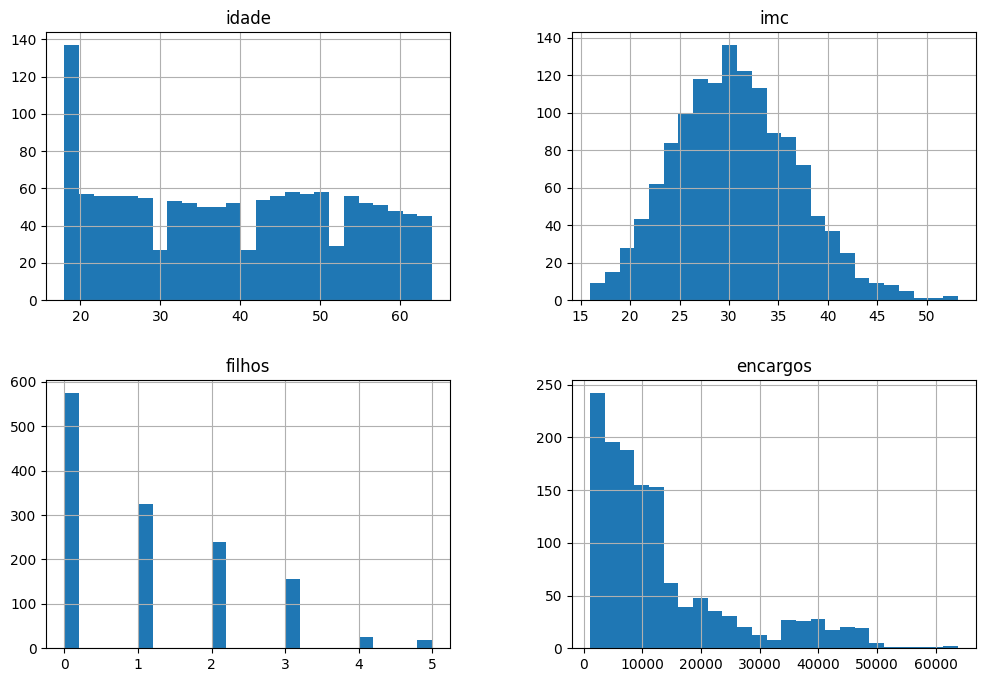

In [ ]:
dataset.hist(bins=25, figsize=(12,8));

Cada histograma representa a distribuição de frequência de uma variável numérica presente em um conjunto de dados. Eles foram gerados a partir do uso da biblioteca do Matplotlib.

**Analisando as variáveis do tipo texto**

In [ ]:
# Listando os elementos existentes na categoria.
set(dataset["gênero"])

{'feminino', 'masculino'}

In [ ]:
# Quantidade de itens por elemento.
dataset["gênero"].value_counts()

,count
gênero,
masculino,676
feminino,662


In [ ]:
# Listando os elementos existentes na categoria.
set(dataset["fumante"])

{'não', 'sim'}

In [ ]:
# Quantidade de itens por elemento.
dataset["fumante"].value_counts()

,count
fumante,
não,1064
sim,274


In [ ]:
# Listando os elementos existentes na categoria.
set(dataset["região"])

{'nordeste', 'noroeste', 'sudeste', 'sudoeste'}

In [ ]:
# Quantidade de itens por elemento.
dataset["região"].value_counts()

,count
região,
sudeste,364
sudoeste,325
noroeste,325
nordeste,324


**Analisando mais detalhamente os dados a partir de gráficos**

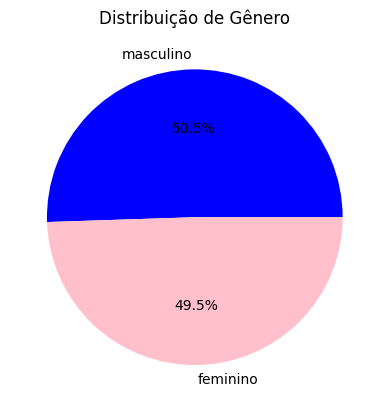

In [ ]:
# Distribuição de gênero
qtt_sexo = dataset['gênero'].value_counts()
plt.pie(qtt_sexo, labels=qtt_sexo.index, autopct='%1.1f%%', colors=["blue", "pink"])
plt.title('Distribuição de Gênero')
plt.show()

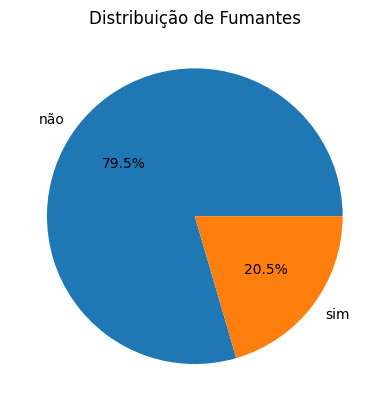

In [ ]:
# Distribuição de fumantes
contador_fumantes = dataset['fumante'].value_counts()
plt.pie(contador_fumantes, labels=contador_fumantes.index, autopct='%1.1f%%')
plt.title('Distribuição de Fumantes')
plt.show()

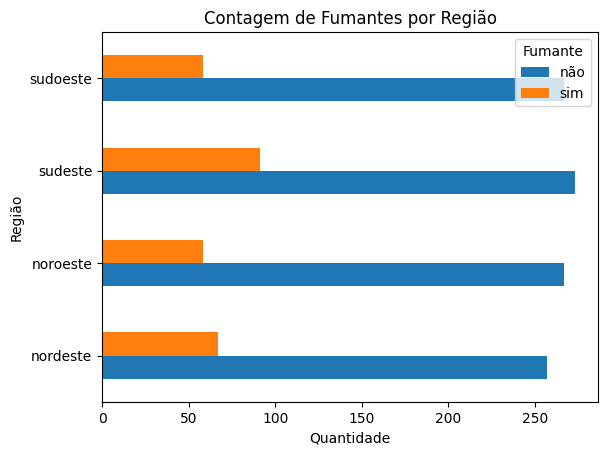

In [ ]:
#Total de fumantes por região
fumante_regiao= dataset.groupby('região')['fumante'].value_counts().unstack().fillna(0)
fumante_regiao.plot(kind='barh')
plt.xlabel('Quantidade')
plt.ylabel('Região')
plt.title('Contagem de Fumantes por Região')
plt.legend(title='Fumante', loc='upper right')
plt.show()

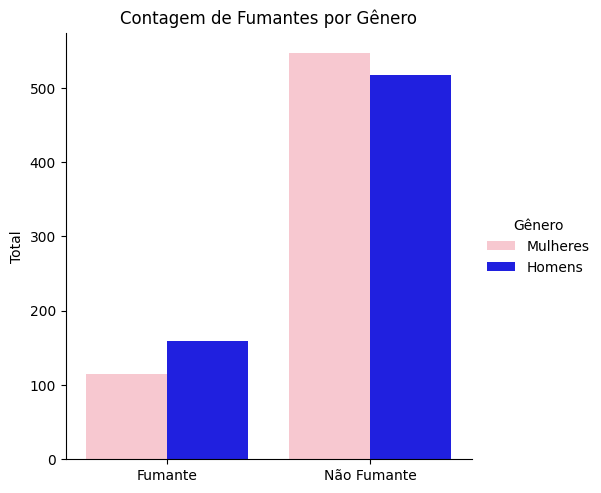

In [ ]:
#Total de fumantes e não fumantes por gênero
custom_palette = ['pink', 'blue']
g = sns.catplot(x='fumante', kind='count', hue = 'gênero', palette=custom_palette, data=dataset, legend_out=True)

(g.set_axis_labels('', 'Total')
  .set_xticklabels(['Fumante', 'Não Fumante'])
  )

g.set(title='Contagem de Fumantes por Gênero')
g._legend.set_title('Gênero')
new_labels = ['Mulheres', 'Homens']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

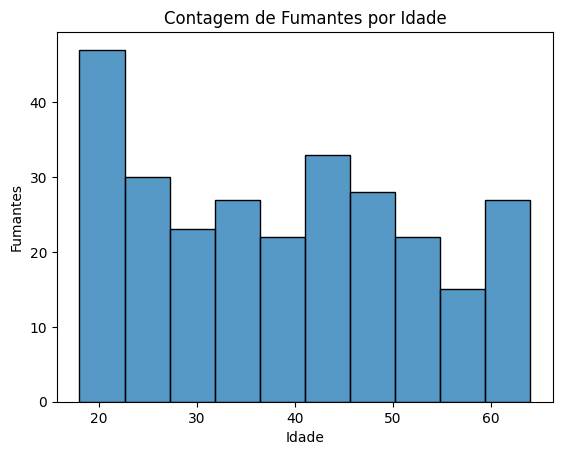

In [ ]:
# Contagem de fumantes por idade
filtered_data = dataset[dataset["fumante"] == "sim"]
sns.histplot(filtered_data["idade"], bins=10)
plt.title("Contagem de Fumantes por Idade")
plt.xlabel("Idade")
plt.ylabel("Fumantes")
plt.show()

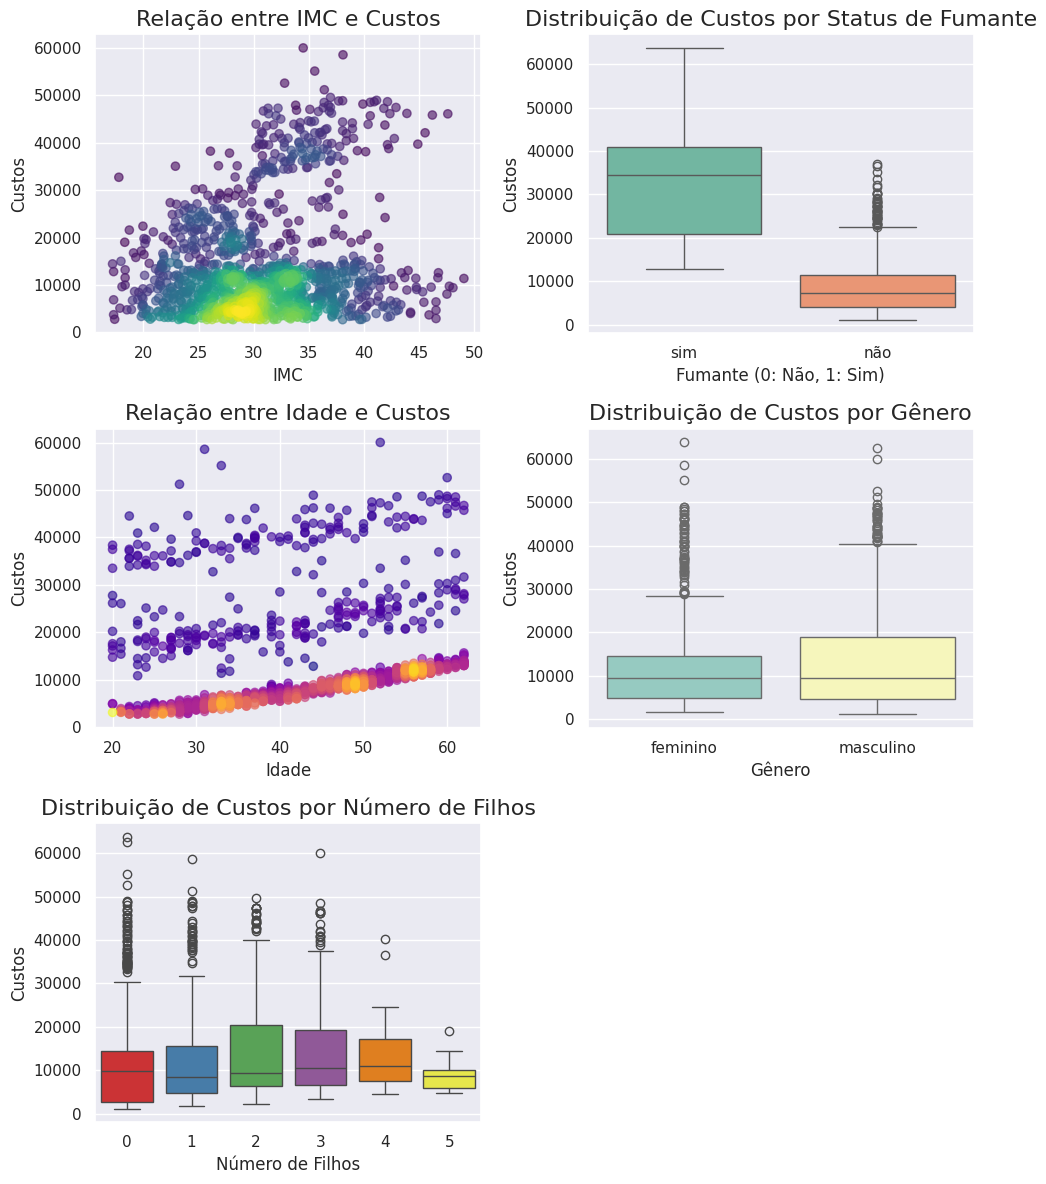

In [ ]:
# Configurar o estilo
sns.set_theme()

# Criar uma figura com subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Função para criar gráficos de dispersão com densidade
def density_scatter(x, y, ax, sort=True, bins=20, **kwargs):
    """
    Scatter plot colorido pela densidade dos pontos
    """
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x,y]).T, method="splinef2d", bounds_error=False)

    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)

# Gráfico para IMC
density_scatter(dataset['imc'], dataset['encargos'], ax=axes[0,0], cmap='viridis', alpha=0.6)
axes[0,0].set_title('Relação entre IMC e Custos', fontsize=16)
axes[0,0].set_xlabel('IMC', fontsize=12)
axes[0,0].set_ylabel('Custos', fontsize=12)

# Gráfico para fumantes/não fumantes
sns.boxplot(x='fumante', y='encargos', data=dataset, ax=axes[0,1], palette='Set2', hue='fumante', legend=False)
axes[0,1].set_title('Distribuição de Custos por Status de Fumante', fontsize=16)
axes[0,1].set_xlabel('Fumante (0: Não, 1: Sim)', fontsize=12)
axes[0,1].set_ylabel('Custos', fontsize=12)

# Gráfico para idade
density_scatter(dataset['idade'], dataset['encargos'], ax=axes[1,0], cmap='plasma', alpha=0.6)
axes[1,0].set_title('Relação entre Idade e Custos', fontsize=16)
axes[1,0].set_xlabel('Idade', fontsize=12)
axes[1,0].set_ylabel('Custos', fontsize=12)

# Gráfico para gênero
sns.boxplot(x='gênero', y='encargos', data=dataset, ax=axes[1,1], palette='Set3', hue='gênero', legend=False)
axes[1,1].set_title('Distribuição de Custos por Gênero', fontsize=16)
axes[1,1].set_xlabel('Gênero', fontsize=12)
axes[1,1].set_ylabel('Custos', fontsize=12)

# Gráfico para filhos
sns.boxplot(x='filhos', y='encargos', data=dataset, ax=axes[2,0], palette='Set1', hue='filhos', legend=False)
axes[2,0].set_title('Distribuição de Custos por Número de Filhos', fontsize=16)
axes[2,0].set_xlabel('Número de Filhos', fontsize=12)
axes[2,0].set_ylabel('Custos', fontsize=12)

# Remover o subplot vazio
fig.delaxes(axes[2,1])

# Ajustar o layout
plt.tight_layout()
plt.show()

A análise dos dados indica que os maiores gastos médicos estão concentrados em:

1. IMC: Há uma tendência geral de aumento nos custos à medida que o IMC aumenta, indicando uma correlação positiva entre IMC e custos médicos.
Mas há uma dispersão considerável dos pontos, o que sugere que, embora haja uma relação, o IMC sozinho não explica completamente a variação nos custos.
2. Fumantes: Os fumantes têm gastos médicos significativamente maiores, refletindo os riscos associados ao tabagismo;
3. Idade: Indivíduos mais velhos enfrentam custos elevados, provavelmente devido ao aumento de condições de saúde e cuidados necessários;
4. Gênero: Homens têm despesas médicas mais altas em comparação com mulheres;
5. Número de Filhos: Aqueles com cerca de 2 filhos também apresentam custos mais elevados, possivelmente relacionados ao estresse e responsabilidades adicionais.

Essas descobertas ajudam a entender quais fatores estão mais associados a altos custos médicos, oferecendo uma base para ajustes nas políticas de seguros e intervenções preventivas.

# **Pré-processando as Categorias**

In [ ]:
# Cópia da base de dados para processamento
proc_dataset = dataset.copy()

**Transformando a categoria "fumante" em valores numéricos.**

In [ ]:
# Cria um objeto OrdinalEncoder
ord_enc = OrdinalEncoder()
# Aplica o metodo fit_transfom no objeto na coluna que selecionada, fazendo com que método aprenda os possíveis valores únicos da coluna (fit) e os codifiqwue em números (transform).
proc_dataset[["fumante"]] = ord_enc.fit_transform(proc_dataset[["fumante"]])
ord_enc.categories_

[array(['não', 'sim'], dtype=object)]

In [ ]:
hot_enc = OneHotEncoder(sparse_output=False)

**Transformando a categoria "gênero" em valores numéricos binários através de criação de novas colunas.**

In [ ]:
#Transformando a variável "gênero" em uma representação numérica binária em um array.
gen_enconded = hot_enc.fit_transform(proc_dataset[["gênero"]])
gen_enconded

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
hot_enc.categories_

[array(['feminino', 'masculino'], dtype=object)]

In [ ]:
#Criando um DataFrame hot_df a partir do array gen_enconded que foi resultado da codificação one-hot.
hot_df = pd.DataFrame(gen_enconded, columns=hot_enc.get_feature_names_out(["gênero"]))
#Concatenando o dataset original dataset com o DataFrame hot_df horizontalmente (axis=1) e sendo armazenado o resultado é armazenado em um novo DataFrame
df_encoded = pd.concat([proc_dataset, hot_df], axis=1)
#Removendo a coluna "gênero" do DataFrame df_encoded e colocando o resultado no dataset original.
proc_dataset = df_encoded.drop("gênero", axis=1)
proc_dataset.head()

,idade,imc,filhos,fumante,região,encargos,gênero_feminino,gênero_masculino
0,19,27.900,0,1.0,sudoeste,16884.92400,1.0,0.0
1,18,33.770,1,0.0,sudeste,1725.55230,0.0,1.0
2,28,33.000,3,0.0,sudeste,4449.46200,0.0,1.0
3,33,22.705,0,0.0,noroeste,21984.47061,0.0,1.0
4,32,28.880,0,0.0,noroeste,3866.85520,0.0,1.0


**Transformando a categoria "região" em valores numéricos binários através de criação de novas colunas.**

In [ ]:
reg_enconded = hot_enc.fit_transform(proc_dataset[["região"]])
reg_enconded

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
hot_enc.categories_

[array(['nordeste', 'noroeste', 'sudeste', 'sudoeste'], dtype=object)]

In [ ]:
hot_df = pd.DataFrame(reg_enconded, columns=hot_enc.get_feature_names_out(["região"]))
df_encoded = pd.concat([proc_dataset, hot_df], axis=1)
proc_dataset = df_encoded.drop("região", axis=1)
proc_dataset.head()

,idade,imc,filhos,fumante,encargos,gênero_feminino,gênero_masculino,região_nordeste,região_noroeste,região_sudeste,região_sudoeste
0,19,27.900,0,1.0,16884.92400,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0.0,1725.55230,0.0,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0.0,4449.46200,0.0,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0.0,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0.0,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0


# **Analisando as Correlações**

In [ ]:
corr = proc_dataset.corr()
corr

,idade,imc,filhos,fumante,encargos,gênero_feminino,gênero_masculino,região_nordeste,região_noroeste,região_sudeste,região_sudoeste
idade,1.000000,0.109272,0.042469,-0.025019,0.299008,0.020856,-0.020856,0.002475,-0.000407,-0.011642,0.010016
imc,0.109272,1.000000,0.012759,0.003750,0.198341,-0.046371,0.046371,-0.138156,-0.135996,0.270025,-0.006205
filhos,0.042469,0.012759,1.000000,0.007673,0.067998,-0.017163,0.017163,-0.022808,0.024806,-0.023066,0.021914
fumante,-0.025019,0.003750,0.007673,1.000000,0.787251,-0.076185,0.076185,0.002811,-0.036945,0.068498,-0.036945
encargos,0.299008,0.198341,0.067998,0.787251,1.000000,-0.057292,0.057292,0.006349,-0.039905,0.073982,-0.043210
gênero_feminino,0.020856,-0.046371,-0.017163,-0.076185,-0.057292,1.000000,-1.000000,0.002425,0.011156,-0.017117,0.004184
gênero_masculino,-0.020856,0.046371,0.017163,0.076185,0.057292,-1.000000,1.000000,-0.002425,-0.011156,0.017117,-0.004184
região_nordeste,0.002475,-0.138156,-0.022808,0.002811,0.006349,0.002425,-0.002425,1.000000,-0.320177,-0.345561,-0.320177
região_noroeste,-0.000407,-0.135996,0.024806,-0.036945,-0.039905,0.011156,-0.011156,-0.320177,1.000000,-0.346265,-0.320829
região_sudeste,-0.011642,0.270025,-0.023066,0.068498,0.073982,-0.017117,0.017117,-0.345561,-0.346265,1.000000,-0.346265


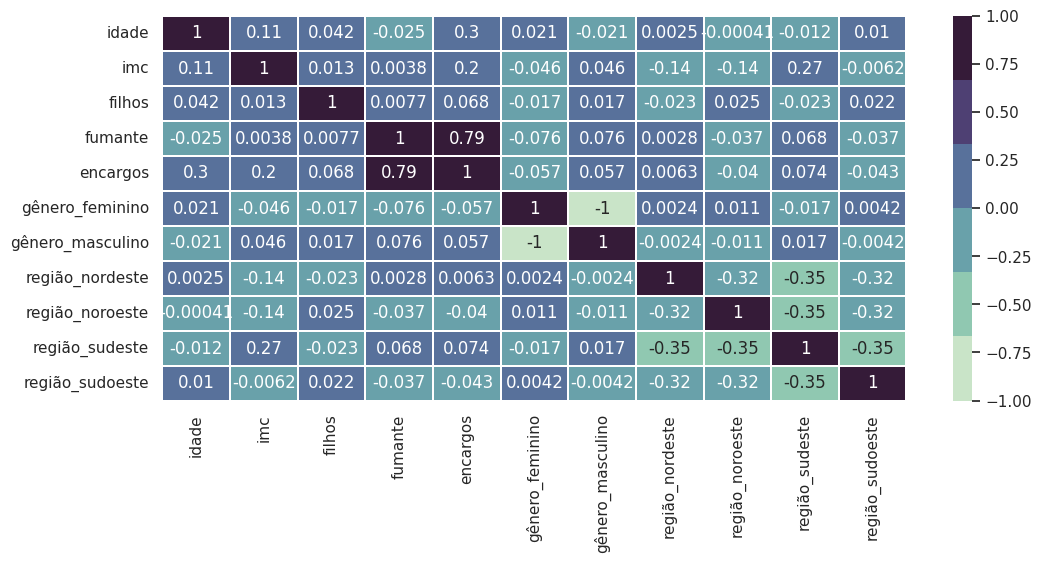

In [ ]:
# Criando o gráfico de calor de correlação
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(corr, cmap=sns.color_palette("ch:s=.70,rot=-.70"), linewidths=.10, annot=True);

A matriz de correlação revela alguns padrões. As pessoas que fumam têm custos de seguro muito mais altos do que as que não fumam, o que indica uma relação significativa que a propensão ao tabagismo que aumenta com os gastos a saúde. Há também uma correlação moderada e positiva entre a idade de um paciente e o IMC, o que parece indicar que as pessoas tendem a ganhar peso à medida que envelhecem. Todos esses insights alinham-se a um entendimento prévio de como o tabagismo e a menor mobilidade/trabalho de órgãos se relacionam com a saúde e podem ser usados para ajustar preços de seguro e priorização de planos de prevenção.


# **Escolhendo o melhor modelo de regressão**

Agora, daremos início à implementação do modelo de regressão, começando pela avaliação de diferentes abordagens. Nosso objetivo é selecionar o modelo que melhor atenderá às necessidades do projeto, garantindo previsões precisas e relevantes para a precificação dos custos médicos.

## **Separando as bases em treino e teste**

In [ ]:
#Separando os dados
x = proc_dataset.drop(['encargos'], axis=1)
y = proc_dataset.encargos

#Separando os dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## **Modelo de Regressão Linear**

O primeiro modelo que será avaliado é o de Regressão Linear, uma técnica fundamental em aprendizado de máquina. Esse modelo assume uma relação linear entre as variáveis independentes (como idade, gênero, IMC, etc.) e a variável dependente, que no nosso caso são os custos médicos. A simplicidade e a interpretabilidade do modelo de Regressão Linear fazem dele um ponto de partida ideal para entender como cada variável contribui para a previsão dos encargos de saúde.

In [ ]:
# Treinando o modelo
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
# Predições usando o modelo
lr_predictions = lr_model.predict(x_test)
# Imprimindo uma pequena amostra
print("Predições:", lr_predictions[:5])

Predições: [ 8969.55027444  7068.74744287 36858.41091155  9454.67850053
 26973.17345656]


**Avaliando o modelo**

In [ ]:
def evaluate_model(y_true, y_pred):
    """
    Avalia as métricas de um modelo.

    Parâmetros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores preditos pelo modelo.

    Retorna:
    dict: Um dicionário contendo as métricas de avaliação.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    return metrics

In [ ]:
# Avaliando o modelo
lr_metrics = evaluate_model(y_test, lr_predictions)
print('RMSE:', lr_metrics['RMSE'])
print('MAE:', lr_metrics['MAE'])
print('R²:', lr_metrics['R2'])

RMSE: 5796.2846592762735
MAE: 4181.194473753641
R²: 0.7835929767120723


O modelo de regressão Linear está funcionando bem, conseguindo acertar 78% das variações nos dados que usamos para a análise. As previsões do modelo podem errar por cerca de 4181 unidades, as estimativas não são perfeitas, mas estão relativamente próximas dos valores reais.

In [ ]:
def plot_predictions(y_test, predictions, label):
  """
    Exibe o gráfico para comparar as predições com os valores reais de teste.

    Parâmetros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores preditos pelo modelo.
    """
  plt.figure(figsize=(12, 5))
  plt.scatter(y_test, predictions, color='green', label=label)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
  plt.title(f'{label}: Real vs. Predições')
  plt.xlabel('Real')
  plt.ylabel('Predições')
  plt.legend()
  plt.show()

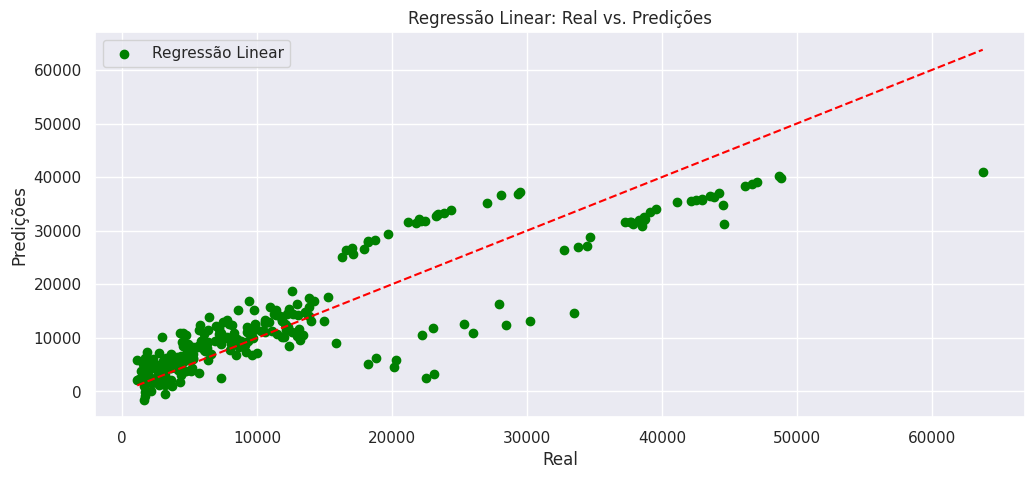

In [ ]:
# Exibindo o gráfico para comparar as predições.
plot_predictions(y_test, lr_predictions, 'Regressão Linear')

## **Modelo de Árvore de Decisão**

O próximo modelo a ser avaliado é a Árvore de Decisão. Diferente da Regressão Linear, que busca relações lineares entre variáveis, a Árvore de Decisão divide os dados em categorias baseadas em decisões sucessivas. Essa abordagem é eficaz para identificar padrões complexos e interações entre variáveis, oferecendo uma visão detalhada sobre como diferentes fatores afetam os custos médicos.

In [ ]:
def find_max_depth(model, X, y, max_depth_range=range(1, 10), cv=5, scoring='r2'):
    """
    Encontra o valor ideal de max_depth para um modelo de regressão de árvore de decisão utilizando R².

    Parâmetros:
    - modelo: modelo de regressão de árvore de decisão (ex: DecisionTreeRegressor)
    - X: Features do conjunto de dados
    - y: Target do conjunto de dados
    - max_depth_range: Intervalo de valores de max_depth para testar (default: range(1, 21))
    - cv: Número de folds para validação cruzada (default: 5)
    - scoring: Métrica de avaliação (default: 'r2')

    Retorno:
    - ideal_depth: O valor ideal de max_depth que maximiza o R² de validação.
    """
    # Lista para armazenar os resultados de validação cruzada
    mean_scores = []

    for depth in max_depth_range:
        # Criação de uma cópia do modelo com a profundidade atual
        modelo_copy = model.set_params(max_depth=depth)

        # Validação cruzada
        scores = cross_val_score(modelo_copy, X, y, cv=cv, scoring=scoring)

        # Armazenar o score médio (média dos valores de R²)
        mean_scores.append(np.mean(scores))

    # Encontrar o índice do maior R²
    ideal_depth = max_depth_range[np.argmax(mean_scores)]

    return ideal_depth

In [ ]:
#Instanciando modelo e definido os parâmetros
#random_state=42 :Estabelecendo o estado de aleatoriedade entre os dados e permitindo a divisão dos dados idênticas.
dtr_model = DecisionTreeRegressor(random_state=42)
# Encontrar o valor ideal de max_depth
best_max_depth = find_max_depth(dtr_model, x, y)
dtr_model.set_params(max_depth=best_max_depth)
#Treinando o modelo
dtr_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [ ]:
# Predições usando o modelo
dtr_predictions = dtr_model.predict(x_test)
# Imprimindo uma pequena amostra
print("Predições:", dtr_predictions[:5])

Predições: [10662.68286257  5703.33875202 27503.00828667 10662.68286257
 35031.66093192]


In [ ]:
# Avaliando o modelo
dtr_metrics = evaluate_model(y_test, dtr_predictions)
print('RMSE:', dtr_metrics['RMSE'])
print('MAE:', dtr_metrics['MAE'])
print('R²:', dtr_metrics['R2'])

RMSE: 4592.764309715603
MAE: 2697.765430538481
R²: 0.8641310379678357


O modelo de Árvore de Decisão demonstrou um desempenho superior em comparação com o modelo de Regressão Linear. Com um R² de aproximadamente 0.86, o modelo de Árvore de Decisão conseguiu explicar 86% das variações nos dados, o que é superior aos 78% alcançados pela Regressão Linear. Além disso, o RMSE (Root Mean Squared Error) da Árvore de Decisão foi de 4592.76, enquanto a Regressão Linear apresentou um erro médio de 4181 unidades, indicando que a Árvore de Decisão é mais precisa na previsão dos custos médicos. O MAE (Mean Absolute Error) de 2697.77 também revela que, em média, os erros das previsões da Árvore de Decisão são menores do que os do modelo de Regressão Linear. Portanto, a Árvore de Decisão não só captura melhor a variabilidade dos dados como também fornece previsões mais próximas dos valores reais.

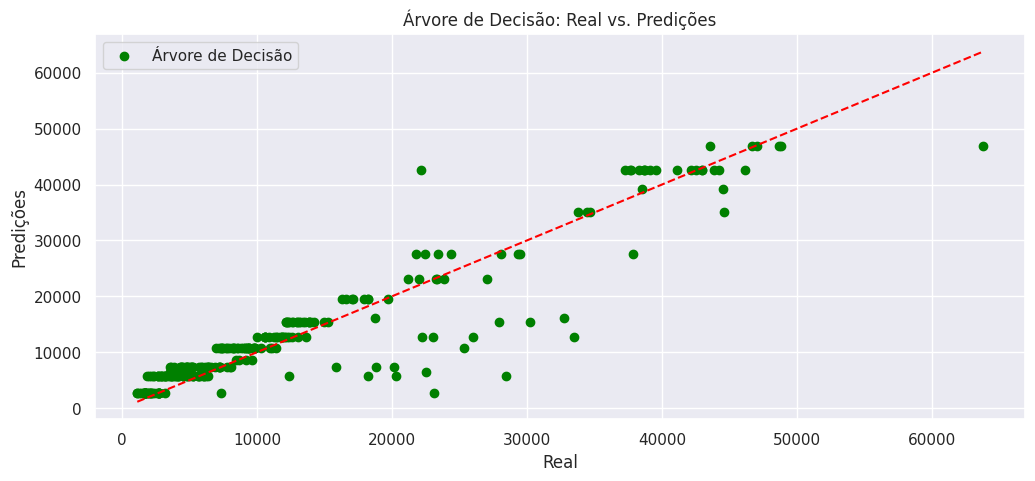

In [ ]:
# Exibindo o gráfico para comparar as predições.
plot_predictions(y_test, dtr_predictions, 'Árvore de Decisão')

## **Modelo Random Forest**

O próximo modelo a ser avaliado é o Random Forest. Esta técnica combina várias árvores de decisão para melhorar a precisão das previsões. Cada árvore é treinada com um subconjunto diferente dos dados, e suas previsões são combinadas para obter um resultado mais confiável. O Random Forest é eficaz para capturar padrões complexos e reduzir o risco de overfitting, oferecendo previsões mais precisas e robustas em comparação com modelos individuais.

In [ ]:
#instanciando modelo e definido os parâmetros
#n_estimators = 100 :Número de árvores na floresta.
#max_depth = 4 :Delimitando a profundidade máxima de cada árvore.
#random_state=42 :Estabelecendo o estado de aleatoriedade entre os dados e permitindo a divisão dos dados idênticas.
rfr_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
#Treinando o modelo
rfr_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=4, random_state=42)

In [ ]:
# Predições usando o modelo
rfr_predictions = rfr_model.predict(x_test)
# Imprimindo uma pequena amostra
print("Predições:", rfr_predictions[:5])

Predições: [ 9955.59309923  6137.45360273 27417.24050086 10056.94523906
 35471.59553234]


In [ ]:
# Avaliando o modelo
rfr_metrics = evaluate_model(y_test, rfr_predictions)
print('RMSE:', rfr_metrics['RMSE'])
print('MAE:', rfr_metrics['MAE'])
print('R²:', rfr_metrics['R2'])

RMSE: 4479.299364405692
MAE: 2607.226950806293
R²: 0.8707614380924689


O modelo Random Forest apresenta um bom desempenho com base nas métricas fornecidas. Ele possui um R² alto de 87% e valores relativamente baixos de RMSE e MAE, o que significa que ele pode explicar uma quantidade substancial da variância nos dados e fazer previsões razoavelmente precisas.

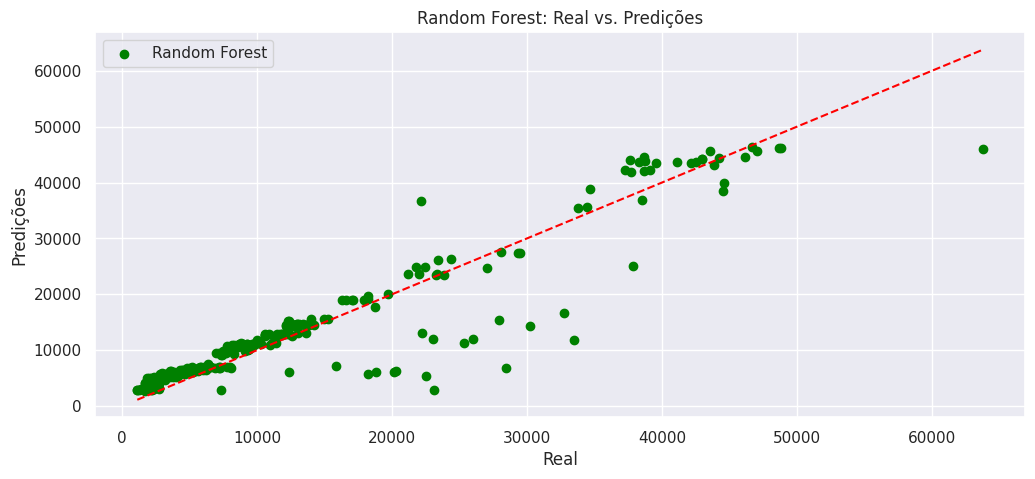

In [ ]:
# Exibindo o gráfico para comparar as predições.
plot_predictions(y_test, rfr_predictions, 'Random Forest')

# **Conclusão**

Após explorarmos e processarmos os dados de forma detalhada, chegamos à etapa final de nossa análise. Agora, apresentaremos os resultados das avaliações dos diferentes modelos preditivos. Vamos focar em demonstrar o desempenho de cada modelo em termos de precisão e eficiência, discutindo as implicações desses resultados para a escolha do modelo mais adequado para prever os custos médicos individuais.

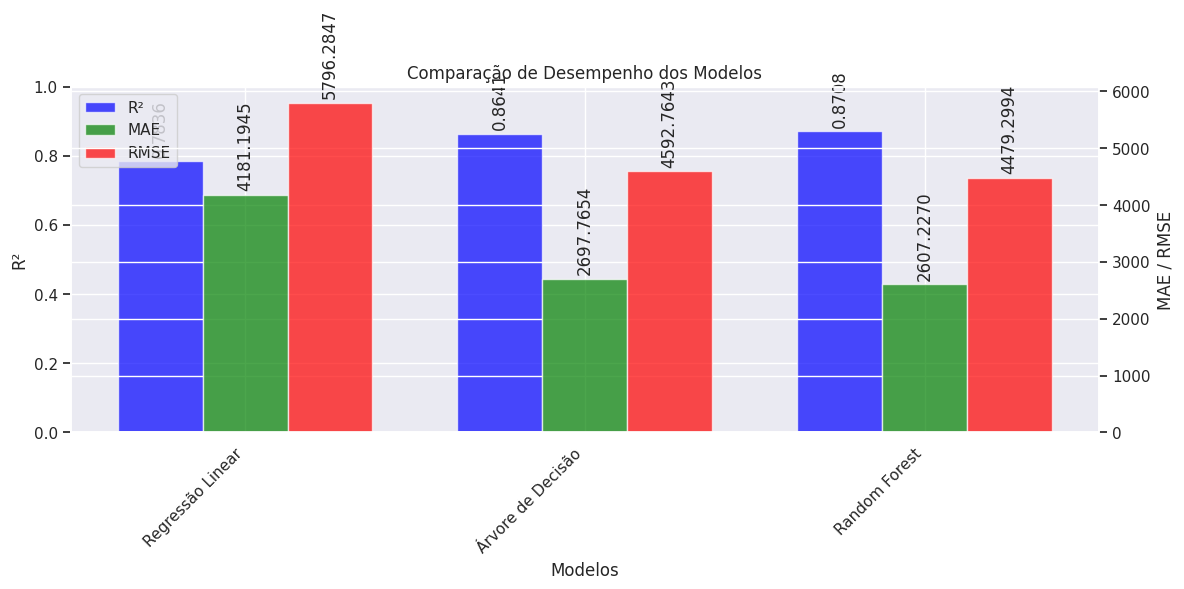

In [ ]:
# Dados
models = ['Regressão Linear', 'Árvore de Decisão', 'Random Forest']
r2_scores = [lr_metrics['R2'], dtr_metrics['R2'], rfr_metrics['R2']]
mae_scores = [lr_metrics['MAE'], dtr_metrics['MAE'], rfr_metrics['MAE']]
rmse_scores = [lr_metrics['RMSE'], dtr_metrics['RMSE'], rfr_metrics['RMSE']]

x = np.arange(len(models))  # posições x para as barras
width = 0.25  # largura das barras

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar R² no eixo y primário
rects1 = ax1.bar(x - width, r2_scores, width, label='R²', color='blue', alpha=0.7)
ax1.set_ylabel('R²')
ax1.set_ylim(0, 1)  # Definir limite do eixo y para R²

# Criar um eixo y secundário para MAE e RMSE
ax2 = ax1.twinx()

# Plotar MAE e RMSE no eixo y secundário
rects2 = ax2.bar(x, mae_scores, width, label='MAE', color='green', alpha=0.7)
rects3 = ax2.bar(x + width, rmse_scores, width, label='RMSE', color='red', alpha=0.7)
ax2.set_ylabel('MAE / RMSE')

# Configurações do gráfico
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação de Desempenho dos Modelos')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

# Combinar as legendas dos dois eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Função para adicionar rótulos nas barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

autolabel(rects1, ax1)
autolabel(rects2, ax2)
autolabel(rects3, ax2)

plt.tight_layout()
plt.show()

Podemos concluir que o Random Forest performou melhor em todas as métricas:

1. Tem o R² mais alto, indicando que explica uma maior proporção da variância nos dados;
2. Tem o MAE mais baixo, mostrando que, em média, suas previsões têm o menor erro absoluto;
3. Tem o RMSE mais baixo, indicando que tem o menor erro quadrático médio, penalizando menos erros grandes.

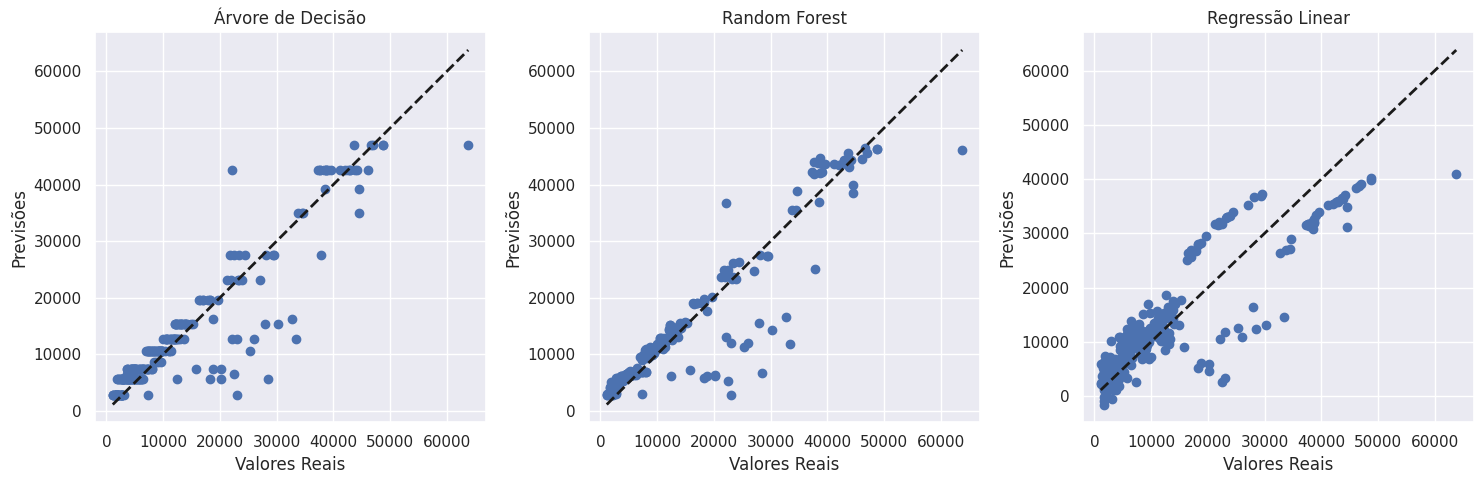

In [ ]:
def plot_multiple_predictions(y_test, predictions_list, model_names):
  """
  Plota múltiplos gráficos de previsões em um único gráfico.

  Args:
    y_test: Valores reais.
    predictions_list: Lista de previsões para cada modelo.
    model_names: Lista com os nomes dos modelos.
  """

  num_models = len(predictions_list)
  fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 5))

  for i, (predictions, model_name) in enumerate(zip(predictions_list, model_names)):
    axes[i].scatter(y_test, predictions)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i].set_xlabel('Valores Reais')
    axes[i].set_ylabel('Previsões')
    axes[i].set_title(model_name)

  plt.tight_layout()
  plt.show()

# Exemplo de uso:
model_names = ['Árvore de Decisão', 'Random Forest', 'Regressão Linear']
predictions_list = [dtr_predictions, rfr_predictions, lr_predictions]

plot_multiple_predictions(y_test, predictions_list, model_names)

Com base na análise apresentada, o modelo Random Forest se mostrou superior aos demais modelos utilizados, apresentando os melhores resultados nas métricas utilizadas: R², RMSE e MAE. Contudo, a escolha de um modelo ideal não pode ser baseada unicamente em valores numéricos. A compactação das regras de escolha desse modelo, a complexidade do problema e a probabilidade de overfitting são exemplos disso. A Árvore de Decisão provavelmente será preterida em favor do Random Forest, pois é mais compreensível. Assim, a escolha de um modelo deve ser realizada com base nas peculiaridades do problema em análise, uma vez que, caso se deseje alcançar as condições de generalização e saber tomar decisões, essa escolha será adequada.